# PyKOALA Data Reduction Sequence (Science data)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import os
from pykoala import __version__
import warnings

# You may want to comment the following line
warnings.filterwarnings("ignore")

# pyKOALA version
print("pyKOALA version: ", __version__)

pyKOALA version:  0.9.0+5.g5680b4c.dirty


In [3]:
from pykoala.instruments.koala_ifu import koala_rss
from pykoala.corrections.atmospheric_corrections import AtmosphericExtCorrection, get_adr
from pykoala.corrections.throughput import Throughput, ThroughputCorrection
from pykoala.cubing import build_cube, build_wcs

atm_ext_corr = AtmosphericExtCorrection()

### Throughput correction

In [4]:
flat_rss = [koala_rss("data/combined_skyflat_red.fits")]
throughput = ThroughputCorrection.create_throughput_from_rss(flat_rss, clear_nan=True)
throughput_corr = ThroughputCorrection(throughput=throughput)

Applying nearest neighbour interpolation to remove NaN values


### Telluric correction

We will use the correction function derived during the standard stars reduction sequence.

In [5]:
from pykoala.corrections.sky import TelluricCorrection

telluric_corr = TelluricCorrection(telluric_correction_file='products/telluric_correction_red.dat', verbose=True)

[Correction: TelluricCorretion] Obtaining telluric correction using spectrophotometric star...
[Correction: TelluricCorretion] Reading telluric correction from input file products/telluric_correction_red.dat


## Load the science data

In [6]:
sci_rss = []
aaomega_arms = {'blue': 1, 'red': 2}
# Choose which arm of the spectrograph is going to be used
arm = 'blue'
path_to_data = 'data'

adr_set = []

#for i in [31, 32, 33]:
for i in [34, 35, 36]:
    filename = f"data/27feb200{i}red.fits"
    rss = koala_rss(filename)

    rss = throughput_corr.apply(rss)
    rss = atm_ext_corr.apply(rss)
    rss = telluric_corr.apply(rss)
    # Telluric
    # Sky
    
    adr_ra, adr_dec, fig = get_adr(rss, plot=True)
    adr_set.append([adr_ra, adr_dec])
    sci_rss.append(rss)

[Correction: TelluricCorretion] Applying telluric correction to this star...
[Correction: TelluricCorretion] Applying telluric correction to this star...
[Correction: TelluricCorretion] Applying telluric correction to this star...


## Astrometry Corrections and Registration

### Image Cross-correlation

The most sofisticated method to perform the registration of extended sources included in pyKOALA is based on the cross-correlation of two images.
### Centroid finding

A simple approach to find the offset between the different RSS is to find the center of light of the images (assuming that they contain the same sources).

In [7]:
from pykoala.corrections.astrometry import AstrometryCorrection

astrom_corr = AstrometryCorrection()
offsets, fig = astrom_corr.register_crosscorr(sci_rss, qc_plot=True)
for offset in offsets:
    print("Offset (ra, dec) in arcsec: ", offset[0].to('arcsec'), offset[1].to('arcsec'))

[Correction: Astrometry] Performing image cross-correlation
[Cubing] Starting cubing process
[Cubing] Initialising new datacube with dimensions: (2048, 86, 164)
[Cubing] Smoothing kernel scale: 7 (pixels)
[Cube] Initialising cube with input HDUL
[Cube] Looking for information in the primary header
NOT IMPLEMENTED
[Cube] Constructing WCS
[Cube] Updating HDUL INTENSITY
[Cube] Updating HDUL variance
[Cube] Constructing wavelength array
[Cubing] Starting cubing process
[Cubing] Initialising new datacube with dimensions: (2048, 86, 164)
[Cubing] Smoothing kernel scale: 7 (pixels)
[Cube] Initialising cube with input HDUL
[Cube] Looking for information in the primary header
NOT IMPLEMENTED
[Cube] Constructing WCS
[Cube] Updating HDUL INTENSITY
[Cube] Updating HDUL variance
[Cube] Constructing wavelength array
[Cubing] Starting cubing process
[Cubing] Initialising new datacube with dimensions: (2048, 86, 164)
[Cubing] Smoothing kernel scale: 7 (pixels)
[Cube] Initialising cube with input HDUL


<Figure size 697.385x431.008 with 0 Axes>

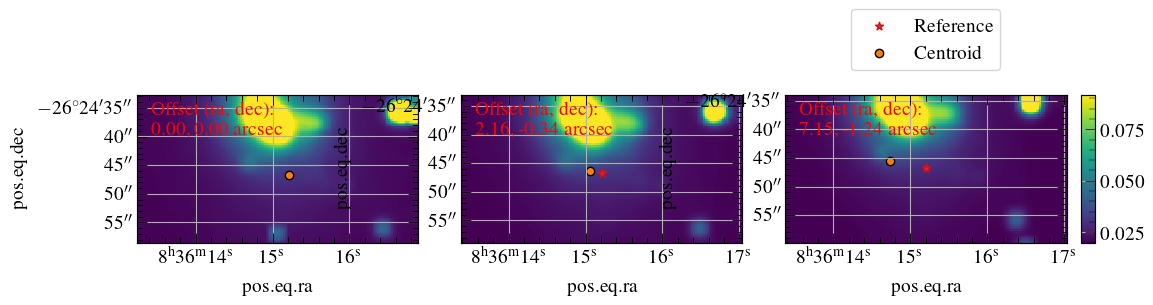

In [8]:
fig

For interpolating RSS data into a 3D datacube we will make use of the function *build_cube*. This method requires as input:
- A list of RSS objects. 
- The desired dimensions of the cube expressed as a 2-element tuple, corresponding to (ra, dec) in arcseconds.
- The pixel size of the cube in arcseconds.
- A list containing the ADR correction for every RSS (it can contain None) in the form: [(ADR_ra_1, ADR_dec_1), (ADR_ra_2, ADR_dec_2), (None, None)].
- Additional information to be included in *cube_info*

In [9]:
datacube_shape = (sci_rss[0].wavelength.size, 40, 60)
ref_position = (sci_rss[0].wavelength[0], np.mean(sci_rss[0].info['fib_ra']), np.mean(sci_rss[0].info['fib_dec']))  # (deg, deg)
spatial_pixel_size = 1.0 / 3600  # (deg)
spectral_pixel_size = sci_rss[0].wavelength[1] - sci_rss[0].wavelength[0]  # (angstrom)

print(f"Creating a WCS with\n position: {ref_position}\n Spatial pixel size: {spatial_pixel_size}\n Spectral pixel size: {spectral_pixel_size}")

wcs = build_wcs(datacube_shape=datacube_shape,
                reference_position=ref_position,
                spatial_pix_size=spatial_pixel_size,
                spectra_pix_size=spectral_pixel_size,
            )

cube = build_cube(rss_set=sci_rss,
                  wcs=wcs,
                  adr_set=adr_set,
                  kernel_size_arcsec=1.0,
                  name=rss.info['name'].split(' ')[0])

Creating a WCS with
 position: (6080.95886230418, 129.06270331213648, -26.412717838960667)
 Spatial pixel size: 0.0002777777777777778
 Spectral pixel size: 1.5751823123400754
[Cubing] Starting cubing process
[Cubing] Initialising new datacube with dimensions: (2048, 60, 40)
[Cubing] Smoothing kernel scale: 2 (pixels)
[Cubing] Smoothing kernel scale: 2 (pixels)
[Cubing] Smoothing kernel scale: 2 (pixels)
[Cube] Initialising cube with input HDUL
[Cube] Looking for information in the primary header
NOT IMPLEMENTED
[Cube] Constructing WCS
[Cube] Updating HDUL INTENSITY
[Cube] Updating HDUL variance
[Cube] Constructing wavelength array


## Sky substraction

In [10]:
import pykoala.corrections.sky as sky
import importlib
importlib.reload(sky)

skymodel = sky.SkyFromObject(cube, bckgr_estimator='mad', source_mask_nsigma=3, remove_cont=False)
skycorrection = sky.SkySubsCorrection(skymodel)
cube, _ = skycorrection.apply(cube)

[SkyModel]  Creating SkyModel from input Data Container
[SkyModel]  Estimating sky background contribution...
[SkyModel]  Pre-estimating background using all data
[SkyModel]  Applying sigma-clipping mask (n-sigma=3)
[Correction: SkyCorrection] Applying sky substraction
[Cube] Updating HDUL INTENSITY
[Cube] Updating HDUL variance


## Absolute flux calibration

[Correction: FluxCalibration] Initialising Flux Calibration (Spectral Throughput)
[Correction: FluxCalibration] Loading response from file products/response_HILT600_transfer_function.dat


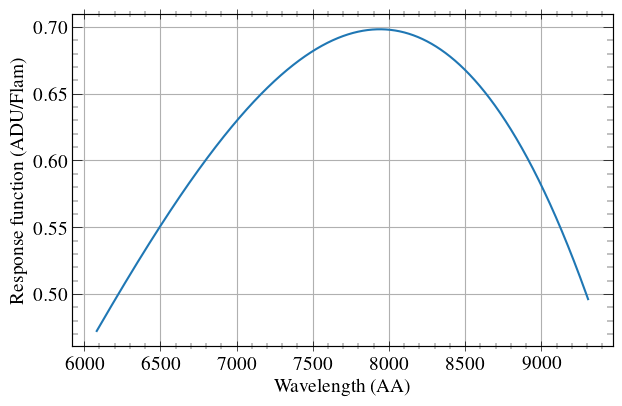

[Correction: FluxCalibration] Applying Flux Calibration to input Cube
[Cube] Updating HDUL INTENSITY
[Cube] Updating HDUL variance
[QCPLOT] Cube QC plot for:  He2-10


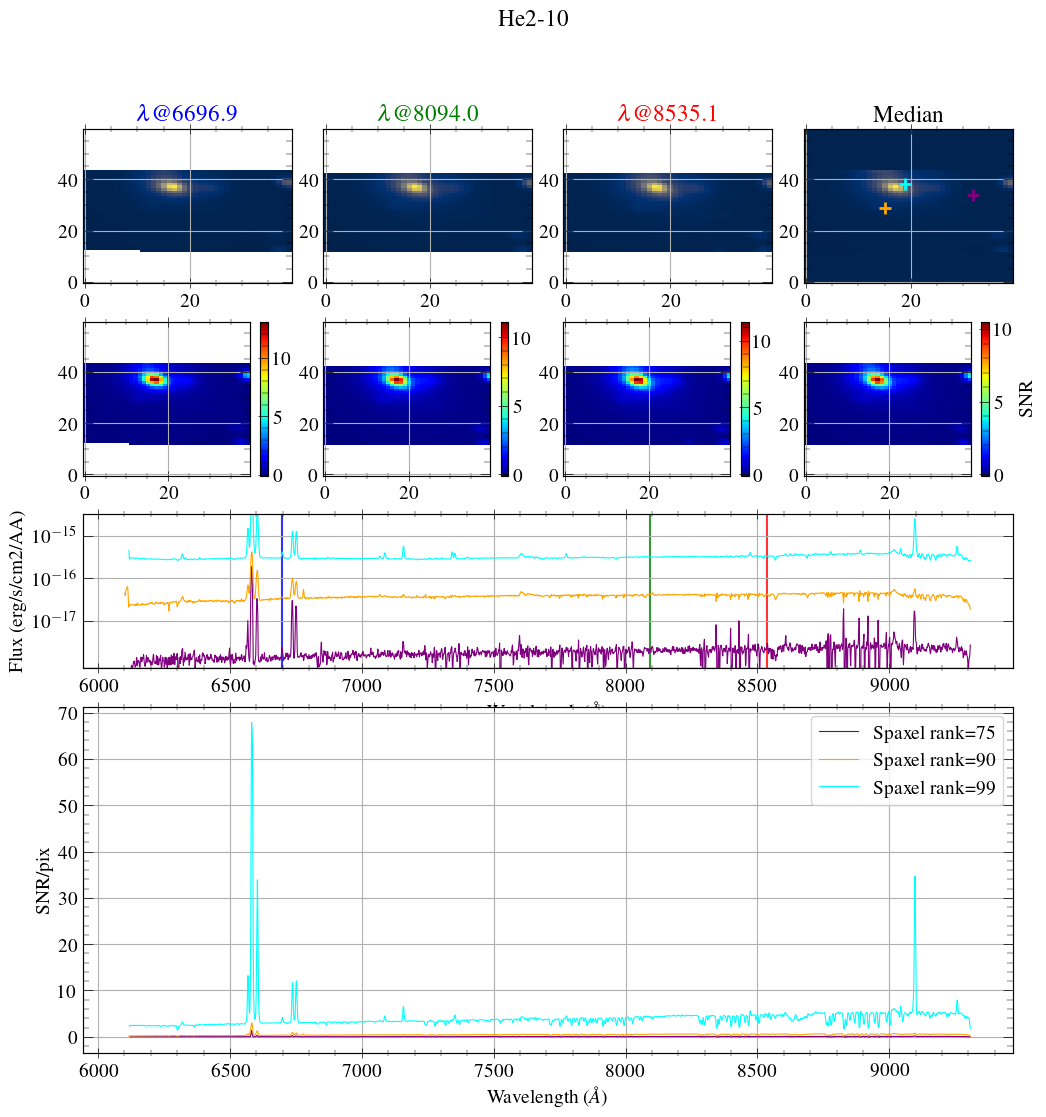

In [11]:
from pykoala.corrections.flux_calibration import FluxCalibration
from pykoala.plotting.qc_plot import qc_cube

fcal = FluxCalibration(path_to_response='products/response_HILT600_transfer_function.dat', verbose=True)

plt.figure()
plt.plot(fcal.resp_wave, fcal.response)
plt.xlabel("Wavelength (AA)")
plt.ylabel("Response function (ADU/Flam)")
plt.show()

cube = fcal.apply(cube)

fig = qc_cube(cube)
plt.show(plt.figure(fig))


In [12]:
# Save the data cube
cube.to_fits("products/Henize_2-10_cube_no_sky.fits.gz")

[Cube] Cube saved at:
 products/Henize_2-10_cube_no_sky.fits.gz
